In [1]:
!pip install datasets tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-

In [2]:
from datasets import load_dataset
ds = load_dataset("roneneldan/TinyStories")

README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [3]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

def process(example):
    ids = enc.encode_ordinary(example['text'])
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc='tokenizing the splits',
        num_proc=8,
    )

    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 256  # Reduced from 1024
        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy', dtype=np.uint16)
            arr_batch = np.concatenate(batch['ids'])
            arr[idx:idx+len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writing train.bin:   0%|          | 0/256 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/256 [00:00<?, ?it/s]

In [4]:
import torch
import numpy as np

device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)
block_size = 128  # context length - matching config
batch_size = 16   # Reduced for P100 memory constraints

def get_batch(split):
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    
    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    
    return x, y

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

@dataclass
class GPTConfig:
    block_size: int 
    vocab_size: int 
    n_layer: int 
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [6]:
config = GPTConfig(
    vocab_size=50304,
    block_size=128,
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)
model = GPT(config).to(device)
print(f"Model parameters: {model.get_num_params():,}")

Model parameters: 29,964,288


In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from contextlib import nullcontext

@dataclass
class TrainingConfig:
    max_iters: int = 10000  # Reduced for P100
    eval_interval: int = 500
    eval_iters: int = 50
    log_interval: int = 100
    
    batch_size: int = 16  # Adjusted for P100
    block_size: int = 128
    gradient_accumulation_steps: int = 4
    
    learning_rate: float = 1e-4
    weight_decay: float = 1e-1
    beta1: float = 0.9
    beta2: float = 0.95
    grad_clip: float = 1.0
    
    decay_lr: bool = True
    warmup_iters: int = 500
    min_lr: float = 5e-5
    
    compile: bool = False  # Disabled for stability on P100
    device: str = device_type
    dtype: str = 'float16' if device_type == 'cuda' else 'float32'
    
    always_save_checkpoint: bool = True
    out_dir: str = 'out'

# Create output directory
os.makedirs('out', exist_ok=True)

train_config = TrainingConfig()

# Setup mixed precision context
if device_type == 'cuda':
    ptdtype = torch.float16 if train_config.dtype == 'float16' else torch.float32
    ctx = torch.amp.autocast(device_type=device_type, dtype=ptdtype)
    scaler = torch.cuda.amp.GradScaler(enabled=(train_config.dtype == 'float16'))
else:
    ctx = nullcontext()
    scaler = None

# Global variables for functions
eval_iters = train_config.eval_iters

def estimate_loss(model, config):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(config.eval_iters)
            for k in range(config.eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out


/tmp/ipykernel_35/3247068638.py:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(train_config.dtype == 'float16'))


In [8]:
import matplotlib.pyplot as plt

# Global variables for tracking
best_val_loss = float('inf')
loss_history = {'train_losses': [], 'val_losses': [], 'iterations': []}

def setup_optimizer_and_scheduler(model, config):
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        betas=(config.beta1, config.beta2),
        weight_decay=config.weight_decay,
        eps=1e-8
    )
    
    cosine_steps = config.max_iters - config.warmup_iters
    
    warmup_scheduler = LinearLR(
        optimizer,
        start_factor=0.01,
        end_factor=1.0,
        total_iters=config.warmup_iters
    )
    
    cosine_scheduler = CosineAnnealingLR(
        optimizer,
        T_max=cosine_steps,
        eta_min=config.min_lr
    )
    
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, cosine_scheduler],
        milestones=[config.warmup_iters]
    )
    
    return optimizer, scheduler

def training_step_with_accumulation(model, optimizer, scaler, X, Y, config):
    with ctx:
        logits, loss = model(X, Y)
        loss = loss / config.gradient_accumulation_steps
    
    if scaler is not None:
        scaler.scale(loss).backward()
    else:
        loss.backward()
    
    return loss.item() * config.gradient_accumulation_steps

def save_checkpoint(model, optimizer, scheduler, iter_num, train_loss, val_loss, config, is_best=False):
    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'iter_num': iter_num,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'config': config,
        'loss_history': loss_history,
    }
    
    if is_best:
        torch.save(checkpoint, os.path.join(config.out_dir, 'best_model.pt'))
        print(f"New best model saved! Val loss: {val_loss:.4f}")
    else:
        torch.save(checkpoint, os.path.join(config.out_dir, f'ckpt_{iter_num}.pt'))

def plot_training_losses():
    if not loss_history['iterations']:
        return
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_history['iterations'], loss_history['train_losses'], 'b-', label='Training', alpha=0.7)
    plt.plot(loss_history['iterations'], loss_history['val_losses'], 'r-', label='Validation', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(loss_history['iterations'], loss_history['val_losses'], 'r-', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [9]:
# Cell 9 - Main training loop
def training_loop(model, train_config):
    global best_val_loss, loss_history
    
    loss_history = {'train_losses': [], 'val_losses': [], 'iterations': []}
    best_val_loss = float('inf')
    
    optimizer, scheduler = setup_optimizer_and_scheduler(model, train_config)
    
    model.train()
    running_loss = 0.0
    
    print(f"Starting training for {train_config.max_iters} iterations...")
    print(f"Device: {device}, Model parameters: {model.get_num_params():,}")
    
    for iter_num in range(train_config.max_iters):
        
        # Evaluation
        if iter_num % train_config.eval_interval == 0 or iter_num == 0:
            losses = estimate_loss(model, train_config)
            
            loss_history['iterations'].append(iter_num)
            loss_history['train_losses'].append(losses['train'].item())
            loss_history['val_losses'].append(losses['val'].item())
            
            print(f"Step {iter_num}: train {losses['train']:.4f}, val {losses['val']:.4f}")
            
            # Save best model
            is_best = losses['val'] < best_val_loss
            if is_best:
                best_val_loss = losses['val']
            
            save_checkpoint(model, optimizer, scheduler, iter_num, 
                          losses['train'], losses['val'], train_config, is_best)
        
        # Training step
        optimizer.zero_grad()
        total_loss = 0.0
        
        for micro_step in range(train_config.gradient_accumulation_steps):
            X, Y = get_batch('train')
            loss = training_step_with_accumulation(model, optimizer, scaler, X, Y, train_config)
            total_loss += loss
        
        # Gradient clipping
        if train_config.grad_clip > 0.0:
            if scaler is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), train_config.grad_clip)
        
        # Optimizer step
        if scaler is not None:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()
        
        scheduler.step()
        
        # Update running loss
        avg_loss = total_loss / train_config.gradient_accumulation_steps
        running_loss = 0.9 * running_loss + 0.1 * avg_loss if iter_num > 0 else avg_loss
        
        # Logging
        if iter_num % train_config.log_interval == 0 and iter_num > 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Iter {iter_num}: loss {avg_loss:.4f}, lr {current_lr:.2e}")
    
    print(f"\nTraining completed! Best val loss: {best_val_loss:.4f}")
    return best_val_loss

In [10]:
@torch.no_grad()
def generate_text(model, prompt, max_new_tokens=50, temperature=0.8, top_k=40):
    model.eval()
    
    enc = tiktoken.get_encoding("gpt2")
    
    # Encode prompt
    prompt_tokens = enc.encode(prompt)
    x = torch.tensor(prompt_tokens, dtype=torch.long, device=device)[None, ...]
    
    # Generate
    for _ in range(max_new_tokens):
        # Crop context if needed
        x_cond = x if x.size(1) <= train_config.block_size else x[:, -train_config.block_size:]
        
        with ctx:
            logits, _ = model(x_cond)
        
        logits = logits[:, -1, :] / temperature
        
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')
        
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        x = torch.cat((x, idx_next), dim=1)
    
    # Decode
    tokens = x[0].tolist()
    generated_text = enc.decode(tokens)
    
    model.train()
    return generated_text

In [11]:
def test_inference(model, test_prompts=None):
    if test_prompts is None:
        test_prompts = [
            "Once upon a time there was a pumpkin",
            "The little girl walked to",
            "In the forest there was a"
        ]
    
    print("\n" + "="*50)
    print("INFERENCE TESTING")
    print("="*50)
    
    for i, prompt in enumerate(test_prompts, 1):
        print(f"\n--- Test {i} ---")
        print(f"Prompt: '{prompt}'")
        try:
            generated = generate_text(model, prompt, max_new_tokens=30, temperature=0.8)
            print(f"Generated: '{generated}'")
        except Exception as e:
            print(f"Error: {e}")
        print("-" * 30)


Starting training...
Starting training for 10000 iterations...
Device: cuda, Model parameters: 29,964,288
Step 0: train 10.9081, val 10.9129
New best model saved! Val loss: 10.9129
Iter 100: loss 9.1054, lr 2.10e-05
Iter 200: loss 7.2428, lr 4.08e-05
Iter 300: loss 5.4347, lr 6.06e-05
Iter 400: loss 4.6529, lr 8.04e-05


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step 500: train 4.1167, val 4.1065
New best model saved! Val loss: 4.1065
Iter 500: loss 4.1626, lr 1.00e-04
Iter 600: loss 3.8750, lr 1.00e-04
Iter 700: loss 3.6875, lr 9.99e-05
Iter 800: loss 3.6204, lr 9.99e-05
Iter 900: loss 3.4088, lr 9.98e-05
Step 1000: train 3.2987, val 3.2983
New best model saved! Val loss: 3.2983
Iter 1000: loss 3.3538, lr 9.97e-05
Iter 1100: loss 3.2765, lr 9.95e-05
Iter 1200: loss 3.1986, lr 9.93e-05
Iter 1300: loss 3.2500, lr 9.91e-05
Iter 1400: loss 3.2225, lr 9.89e-05
Step 1500: train 2.9705, val 2.9722
New best model saved! Val loss: 2.9722
Iter 1500: loss 3.1152, lr 9.86e-05
Iter 1600: loss 2.9178, lr 9.84e-05
Iter 1700: loss 2.9607, lr 9.81e-05
Iter 1800: loss 2.8840, lr 9.77e-05
Iter 1900: loss 2.8760, lr 9.74e-05
Step 2000: train 2.7860, val 2.7791
New best model saved! Val loss: 2.7791
Iter 2000: loss 2.7433, lr 9.70e-05
Iter 2100: loss 2.8905, lr 9.66e-05
Iter 2200: loss 2.8138, lr 9.61e-05
Iter 2300: loss 2.7205, lr 9.57e-05
Iter 2400: loss 2.9236

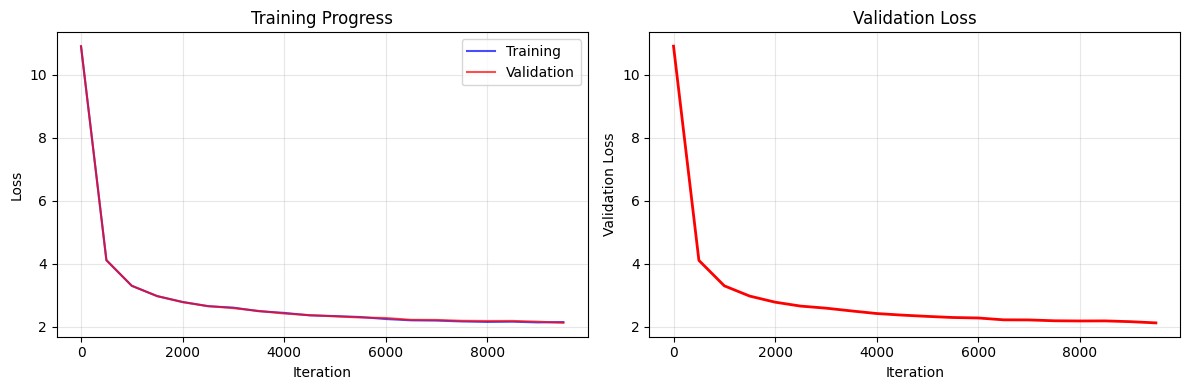

In [12]:
print("Starting training...")
best_loss = training_loop(model, train_config)

# Plot results
print("\nPlotting training curves...")
plot_training_losses()

In [13]:
print("\nTesting text generation...")
test_inference(model, ["Once upon a time there was a pumpkin"])

print("\nTraining and testing completed!")
print(f"Best validation loss achieved: {best_loss:.4f}")
print("Checkpoints saved in 'out/' directory")


Testing text generation...

INFERENCE TESTING

--- Test 1 ---
Prompt: 'Once upon a time there was a pumpkin'
Generated: 'Once upon a time there was a pumpkin. It was an ordinary pumpkin. Every day, it would take the pumpkin to the barn.

One day, a little girl came to the'
------------------------------

Training and testing completed!
Best validation loss achieved: 2.1206
Checkpoints saved in 'out/' directory


In [14]:
print("\nTesting text generation...")
test_inference(model, ["In the forest there is a lion"])


Testing text generation...

INFERENCE TESTING

--- Test 1 ---
Prompt: 'In the forest there is a lion'
Generated: 'In the forest there is a lion. The lion is brown and shiny. He can fly and laugh. He likes to play with his friends. He also likes to help his friends.'
------------------------------
